# 二部网络鲁棒性分析

- 评估网络鲁棒性：在不同节点移除策略下，二部生态网络在功能上能坚持到什么程度。
- 找出关键物种/节点：哪些节点最影响网络连通性与稳定性。
- 对比策略与网络：比较不同网络（Prunus、Pollinator）和不同移除策略的表现，给出结论性解释。

In [42]:
# 环境初始化（跨设备、无需绝对路径）
from pathlib import Path
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import json
import seaborn as sns
from collections import defaultdict

# 自动定位仓库根目录：向上寻找同时包含 src/ 与 tests/ 的目录
def find_repo_root(start: Path = Path.cwd()) -> Path:
    for p in [start, *start.parents]:
        if (p / 'src').exists() and (p / 'tests').exists():
            return p
    return start  # 兜底：当前目录

REPO_ROOT = find_repo_root()
BASE_RESULTS = REPO_ROOT / 'tests' / 'results'

# 强制英文字体（与原配置一致）
plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

print(f"Repo root: {REPO_ROOT}")
print("环境初始化完成（使用相对路径）")

Repo root: /Users/limengxiao/Desktop/info/M2/AALA/projet_trois/AAGA_Robustesse_Reseaux_Bipartis
环境初始化完成（使用相对路径）


In [43]:
# 数据加载函数（支持相对仓库根目录的路径）
def load_bipartite_from_json(file_path, directed=True):
    # 将相对路径解析到仓库根目录 REPO_ROOT
    fp = Path(file_path)
    if not fp.is_absolute():
        fp = REPO_ROOT / fp
    with open(fp, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    
    # 添加节点
    for node in data["nodes"]:
        # 使用group字段，并映射到type
        group = node.get("group", "unknown")
        if group in ["Herbivore", "Pollinator"]:
            node_type = "active"
        elif group == "Plant":
            node_type = "passive"
        else:
            node_type = "unknown"
        
        G.add_node(node["nodeid"], name=node["name"], type=node_type)
    
    # 创建ID映射（从整数ID到字符串nodeid）
    id_mapping = {}
    for i, node in enumerate(data["nodes"]):
        id_mapping[i] = node["nodeid"]  # 使用索引作为整数ID
    
    # 添加边
    for link in data["links"]:
        source_id = id_mapping[link["source"]]
        target_id = id_mapping[link["target"]]
        G.add_edge(source_id, target_id)
    
    return G

print("数据加载函数定义完成")

数据加载函数定义完成


In [44]:
# 论文标准可视化函数
def visualize_network_with_importance(G, active_nodes, passive_nodes, 
                                    active_scores, passive_scores, 
                                    title, figsize=(24, 16), show_labels=True):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
 
    MORANDI_COLORS = {
        "high": "#8B7D6B",     
        "medium": "#A8B5A0",   
        "low": "#C4B5A0",      
        "edge": "#6B7B8C",     
        "label_bg": "#E8E0D0",  
        "label_border": "#8B7D6B", 
        "text": "#4A4A4A"       
    }
    
    # 计算节点大小（基于重要性）
    def calculate_node_sizes(nodes, scores, base_size=300, max_size=800):
        if not scores:
            return [base_size] * len(nodes)
        
        max_score = max(scores.values()) if scores.values() else 1
        min_score = min(scores.values()) if scores.values() else 0
        
        if max_score == min_score:
            return [base_size] * len(nodes)
        
        sizes = []
        for node in nodes:
            score = scores.get(node, 0)
            normalized_score = (score - min_score) / (max_score - min_score)
            size = base_size + normalized_score * (max_size - base_size)
            sizes.append(size)
        return sizes
    
    # 计算边宽度（基于连接强度）
    def calculate_edge_widths(G, base_width=0.5, max_width=2.0):
        if G.number_of_edges() == 0:
            return []
        
        edge_weights = []
        for edge in G.edges():
            source, target = edge
            source_importance = active_scores.get(source, 0) + passive_scores.get(source, 0)
            target_importance = active_scores.get(target, 0) + passive_scores.get(target, 0)
            edge_weight = source_importance + target_importance
            edge_weights.append(edge_weight)
        
        if not edge_weights:
            return [base_width] * G.number_of_edges()
        
        max_weight = max(edge_weights)
        min_weight = min(edge_weights)
        
        if max_weight == min_weight:
            return [base_width] * len(edge_weights)
        
        widths = []
        for weight in edge_weights:
            normalized_weight = (weight - min_weight) / (max_weight - min_weight)
            width = base_width + normalized_weight * (max_width - base_width)
            widths.append(width)
        return widths
    
    # 按重要性排序节点（重要节点在上方）
    active_sorted = sorted(active_nodes, key=lambda x: active_scores.get(x, 0), reverse=True)
    passive_sorted = sorted(passive_nodes, key=lambda x: passive_scores.get(x, 0), reverse=True)
    
    # 计算节点大小（重要节点在上方）
    active_sizes = calculate_node_sizes(active_sorted, active_scores)
    passive_sizes = calculate_node_sizes(passive_sorted, passive_scores)
    
    # 创建布局（重要节点在上方）
    pos = {}
    
    # 主动节点在左侧（重要节点在上方）- 修复排序问题
    for i, node in enumerate(active_sorted):
        pos[node] = (0, len(active_sorted) - i - 1)  # 反转Y坐标，重要节点在上方
    
    # 被动节点在右侧（间隔到图齐平，按重要性排序）
    max_height = max(len(active_sorted), len(passive_sorted))
    if len(passive_sorted) > 1:
        # 被动物种均匀分布到整个图的高度，按重要性排序
        for i, node in enumerate(passive_sorted):
            y_pos = (len(passive_sorted) - i - 1) * (max_height - 1) / (len(passive_sorted) - 1)  # 反转Y坐标，重要节点在上方
            pos[node] = (6, y_pos)
    else:
        if len(passive_sorted) == 1:
            pos[passive_sorted[0]] = (6, max_height / 2)
    
    # 计算边宽度
    edge_widths = calculate_edge_widths(G)
    
    # 绘制边（降低透明度，避免黑色遮挡）
    if edge_widths:
        nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color=MORANDI_COLORS["edge"], 
                              width=edge_widths, arrows=True, arrowsize=25, 
                              arrowstyle="->", ax=ax)
    else:
        nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color=MORANDI_COLORS["edge"], 
                              width=0.8, arrows=True, arrowsize=25, 
                              arrowstyle="->", ax=ax)
    
    # 绘制主动节点（重要节点在上方）
    active_colors = []
    for i, node in enumerate(active_sorted):
        # 根据排序位置分配颜色（重要节点在上方）
        if i < len(active_sorted) * 0.2:  # 前20%为高重要性
            active_colors.append(MORANDI_COLORS["high"])
        elif i < len(active_sorted) * 0.5:  # 20%-50%为中等重要性
            active_colors.append(MORANDI_COLORS["medium"])
        else:
            active_colors.append(MORANDI_COLORS["low"])
    
    nx.draw_networkx_nodes(G, pos, nodelist=active_sorted, 
                          node_color=active_colors, node_size=active_sizes, 
                          alpha=0.8, edgecolors="#4A4A4A", linewidths=1, ax=ax)
    
    # 绘制被动节点（重要节点在上方）
    passive_colors = []
    for i, node in enumerate(passive_sorted):
        # 根据排序位置分配颜色（重要节点在上方）
        if i < len(passive_sorted) * 0.2:  # 前20%为高重要性
            passive_colors.append(MORANDI_COLORS["high"])
        elif i < len(passive_sorted) * 0.5:  # 20%-50%为中等重要性
            passive_colors.append(MORANDI_COLORS["medium"])
        else:
            passive_colors.append(MORANDI_COLORS["low"])
    
    nx.draw_networkx_nodes(G, pos, nodelist=passive_sorted, 
                          node_color=passive_colors, node_size=passive_sizes, 
                          alpha=0.8, edgecolors="#4A4A4A", linewidths=1, ax=ax)
    
    # 只为重要节点添加标签（完全避免遮挡）- 只在show_labels=True时显示
    if show_labels:
        def add_important_labels(G, pos, nodes, scores, top_n=5, side_offset=1.0, label_length=10, show_labels_flag=True):
            if not scores or not show_labels_flag:
                return
            
            sorted_nodes = sorted(nodes, key=lambda x: scores.get(x, 0), reverse=True)[:top_n]
            
            for node in sorted_nodes:
                node_name = G.nodes[node]["name"][:label_length]
                x, y = pos[node]
                # 标签写在远离节点的位置，完全避免遮挡
                ax.text(x + side_offset, y, node_name, 
                       fontsize=12, color=MORANDI_COLORS["text"], 
                       fontweight="bold", ha="left" if side_offset > 0 else "right", va="center",
                       bbox=dict(boxstyle="round,pad=0.3", facecolor=MORANDI_COLORS["label_bg"], 
                                alpha=0.9, edgecolor=MORANDI_COLORS["label_border"], linewidth=1))
        
        # 添加重要节点标签（远离节点，避免遮挡）
        add_important_labels(G, pos, active_sorted, active_scores, top_n=5, side_offset=1.0)
        add_important_labels(G, pos, passive_sorted, passive_scores, top_n=len(passive_sorted), side_offset=-1.0)
    
    # 标题放在正上方（字体放大）
    ax.set_title(f"{title}\nNode size = Importance, Edge width = Connection strength", 
                fontsize=22, fontweight="bold", pad=30, color=MORANDI_COLORS["text"])
    
    # 侧边标签（始终显示，不管show_labels参数）
    ax.text(-1.2, max_height / 2, "Active Species\n(Decreasing Importance)", 
            ha="right", va="center", fontsize=18, fontweight="bold", 
            rotation=90, bbox=dict(boxstyle="round,pad=0.6", facecolor=MORANDI_COLORS["label_bg"], 
                                   alpha=0.9, edgecolor=MORANDI_COLORS["label_border"], linewidth=1),
            color=MORANDI_COLORS["text"])
    ax.text(7.2, max_height / 2, "Passive Species\n(Decreasing Vulnerability)", 
            ha="left", va="center", fontsize=18, fontweight="bold", 
            rotation=90, bbox=dict(boxstyle="round,pad=0.6", facecolor=MORANDI_COLORS["label_bg"], 
                                   alpha=0.9, edgecolor=MORANDI_COLORS["label_border"], linewidth=1),
            color=MORANDI_COLORS["text"])
    
    ax.set_xlim(-2.5, 8.5)
    ax.set_ylim(-0.5, max_height + 0.5)
    ax.axis("off")
    
    plt.tight_layout()
    plt.show()

print("可视化函数定义完成")

可视化函数定义完成


=== Prunus Network Analysis ===
Prunus网络: 64个主动节点, 5个被动节点


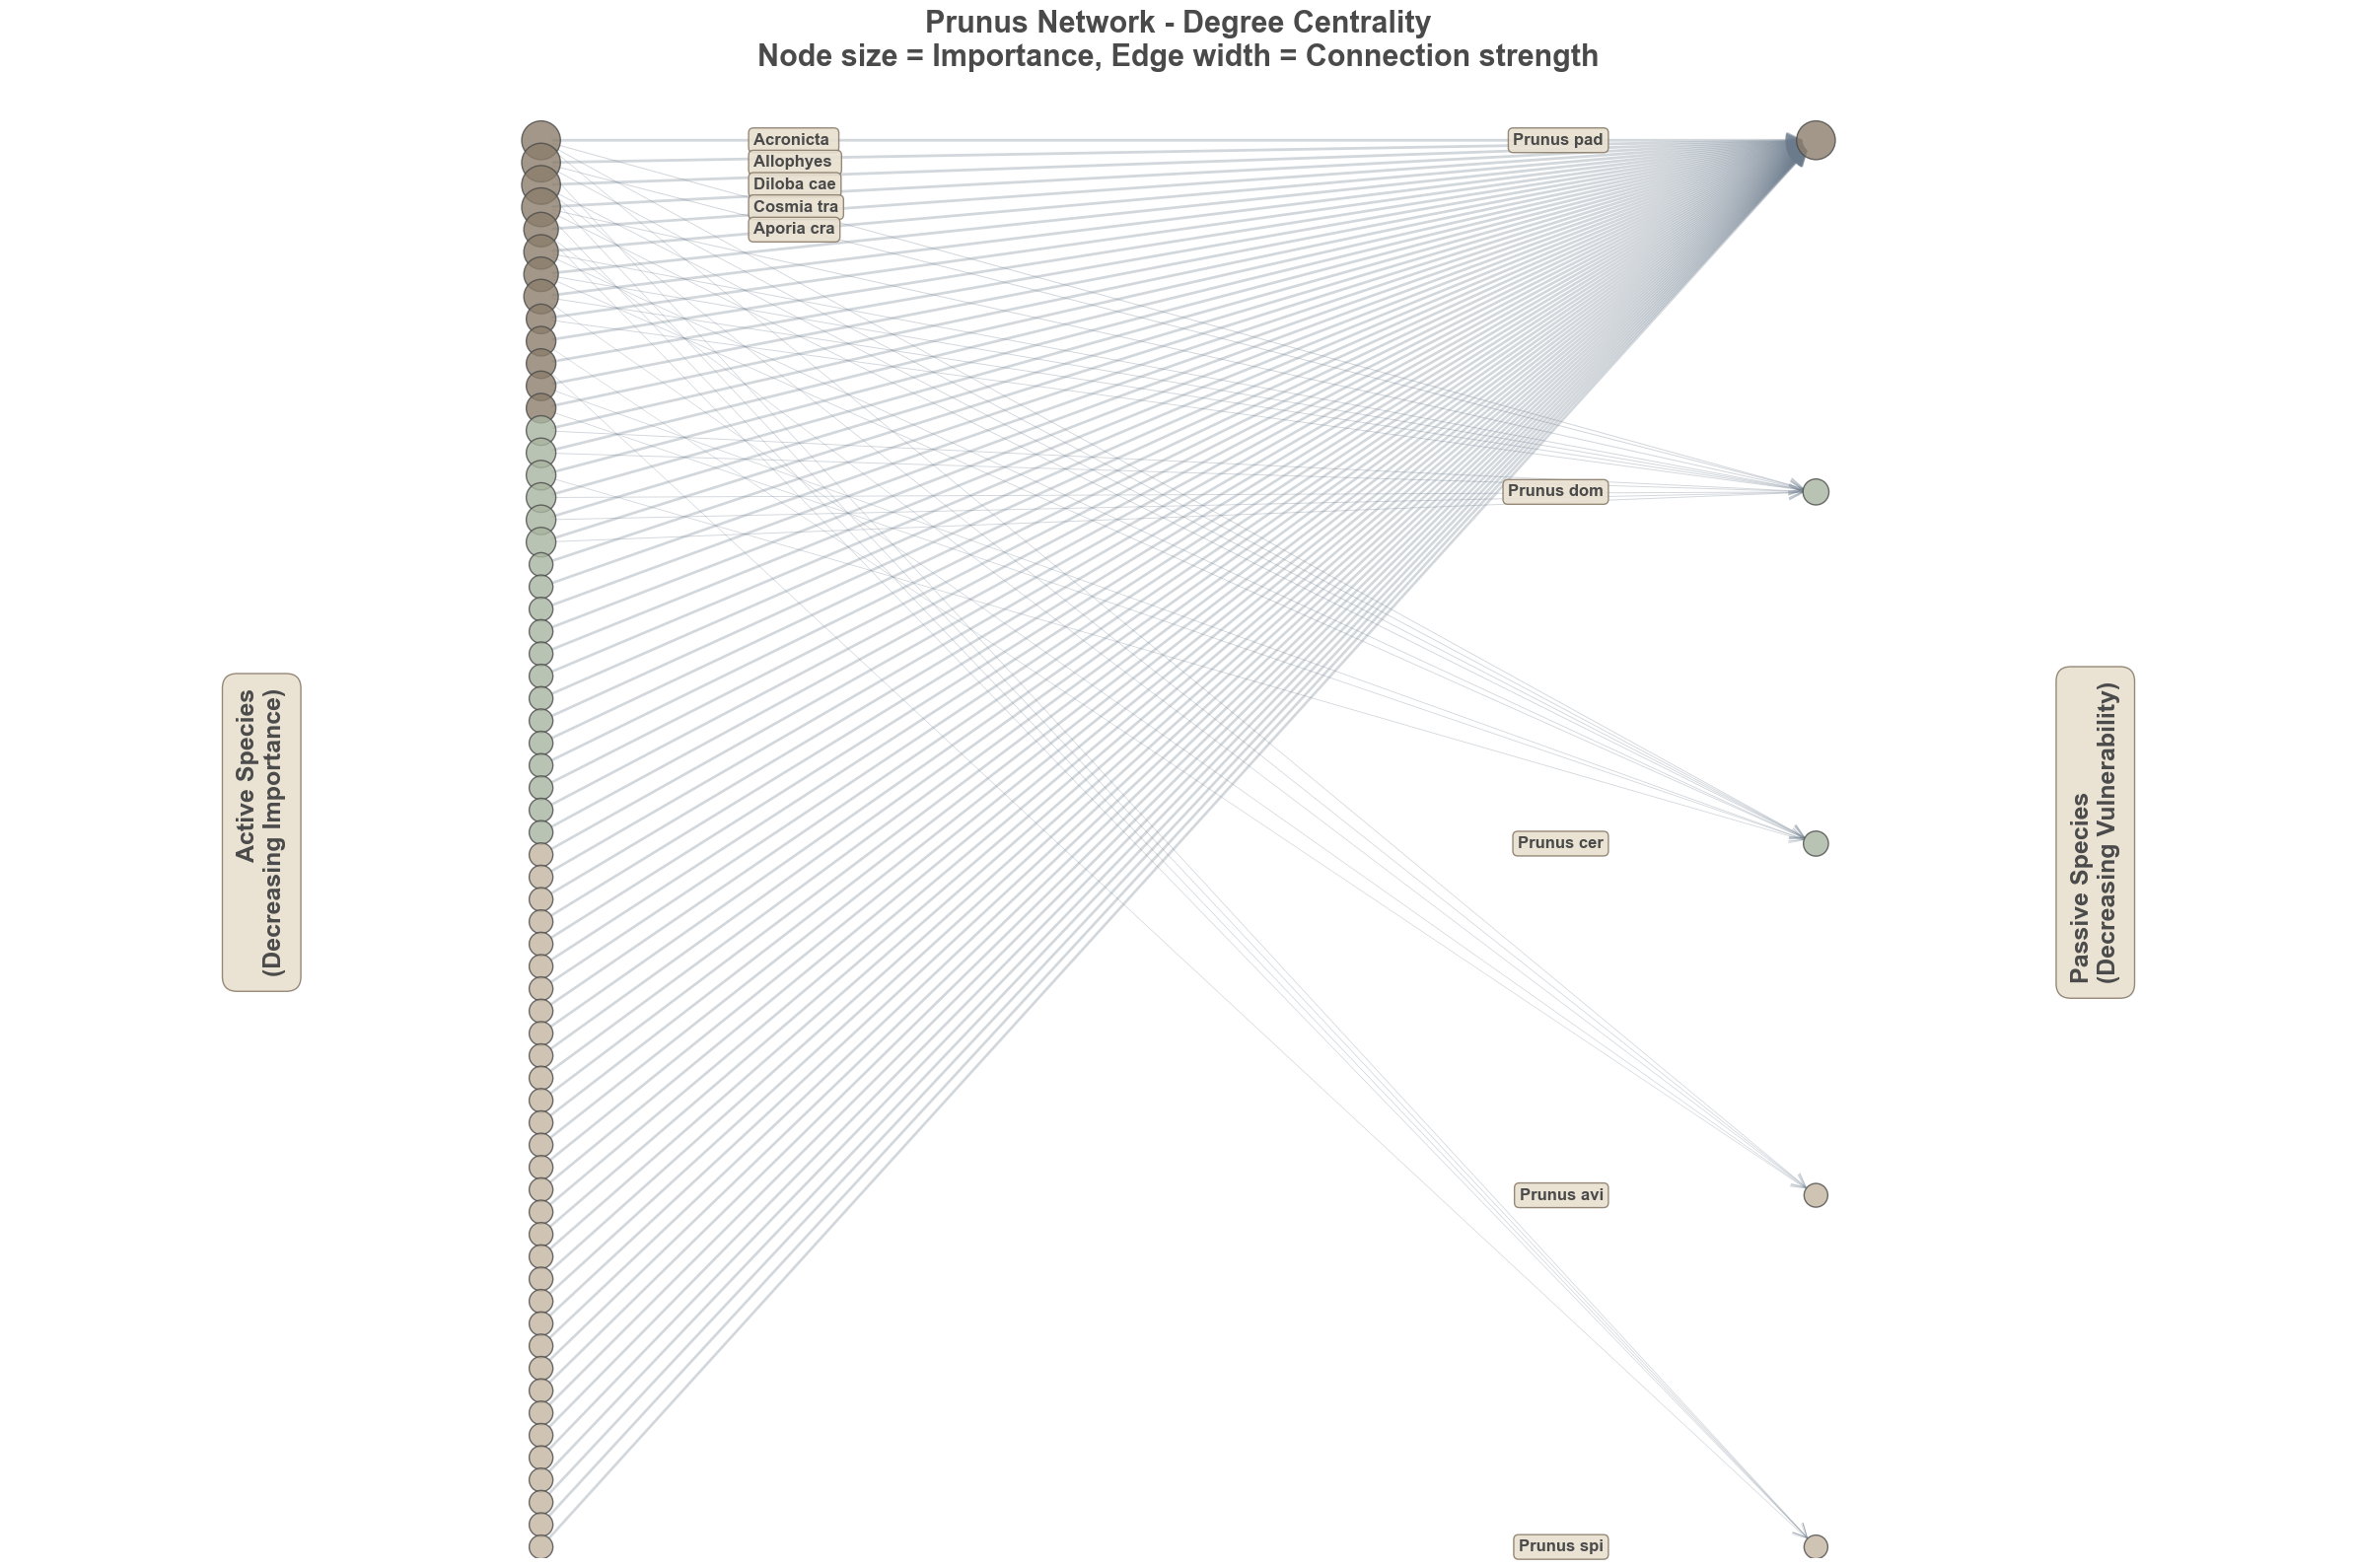

Prunus network analysis completed

=== Pollinator Network Analysis ===
Pollinator网络: 677个主动节点, 91个被动节点


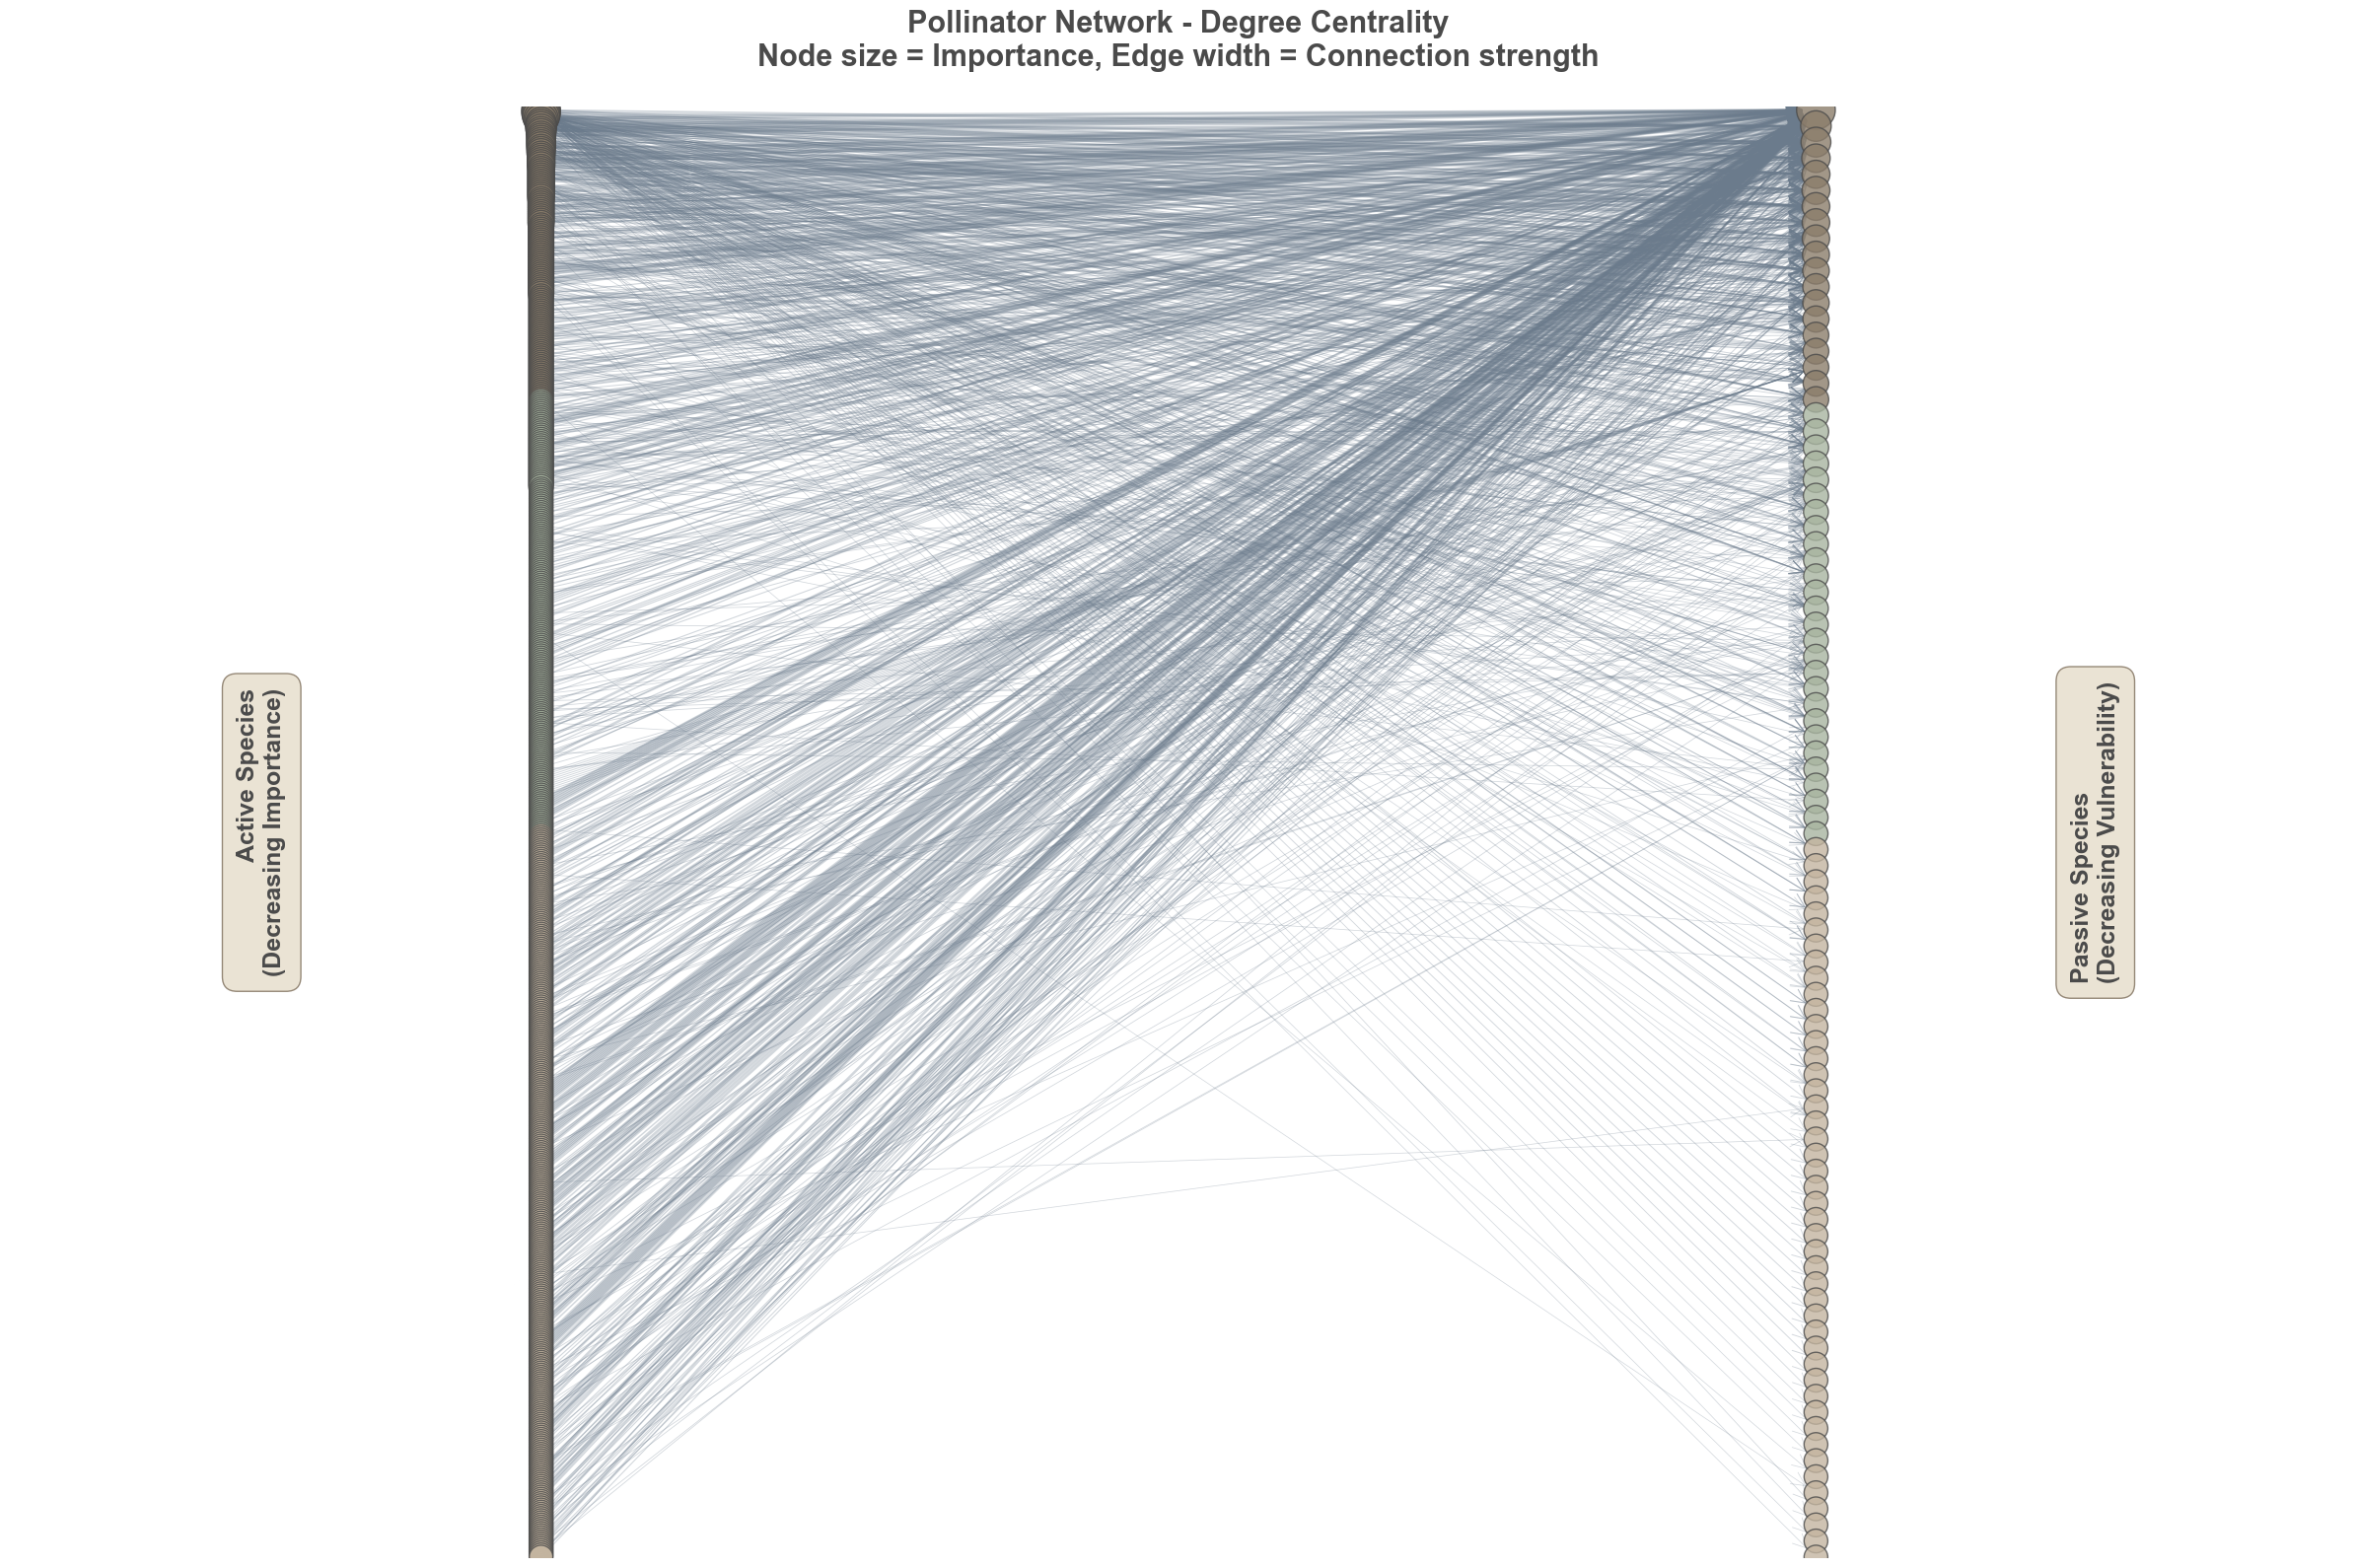

Pollinator network analysis completed


In [45]:
# 数据加载和可视化演示
print("=== Prunus Network Analysis ===")

# 加载Prunus网络
G_prunus = load_bipartite_from_json("tests/network_prunus.json", directed=True)

# 分离主动和被动节点
active_prunus = [node for node in G_prunus.nodes() if G_prunus.nodes[node]["type"] == "active"]
passive_prunus = [node for node in G_prunus.nodes() if G_prunus.nodes[node]["type"] == "passive"]

print(f"Prunus网络: {len(active_prunus)}个主动节点, {len(passive_prunus)}个被动节点")

# 计算Degree中心性
degree_prunus = dict(G_prunus.out_degree(active_prunus))
passive_in_degree_prunus = dict(G_prunus.in_degree(passive_prunus))

# 可视化网络（显示标签）
visualize_network_with_importance(G_prunus, active_prunus, passive_prunus,
                                degree_prunus, passive_in_degree_prunus,
                                "Prunus Network - Degree Centrality", show_labels=True)

print("Prunus network analysis completed")

# 加载Pollinator网络
print("\n=== Pollinator Network Analysis ===")
G_pollinator = load_bipartite_from_json("tests/networkjson_pollinator.json", directed=True)

# 分离主动和被动节点
active_pollinator = [node for node in G_pollinator.nodes() if G_pollinator.nodes[node]["type"] == "active"]
passive_pollinator = [node for node in G_pollinator.nodes() if G_pollinator.nodes[node]["type"] == "passive"]

print(f"Pollinator网络: {len(active_pollinator)}个主动节点, {len(passive_pollinator)}个被动节点")

# 计算Degree中心性
degree_pollinator = dict(G_pollinator.out_degree(active_pollinator))
passive_in_degree_pollinator = dict(G_pollinator.in_degree(passive_pollinator))

# 可视化网络（不显示标签）
visualize_network_with_importance(G_pollinator, active_pollinator, passive_pollinator,
                                degree_pollinator, passive_in_degree_pollinator,
                                "Pollinator Network - Degree Centrality", show_labels=False)

print("Pollinator network analysis completed")


Step 1: Data Preprocessing

Processing Prunus network...

1.1 Network construction:
  - Bipartite network structure:
    * active: 64 nodes
    * passive: 5 nodes
  - Total edges (interactions): 95

  - Adjacency matrix A[i,j]:
    * Matrix shape: (69, 69)
    * A[i,j] = 1 if species i and j interact, 0 otherwise
    * Number of interactions: 95


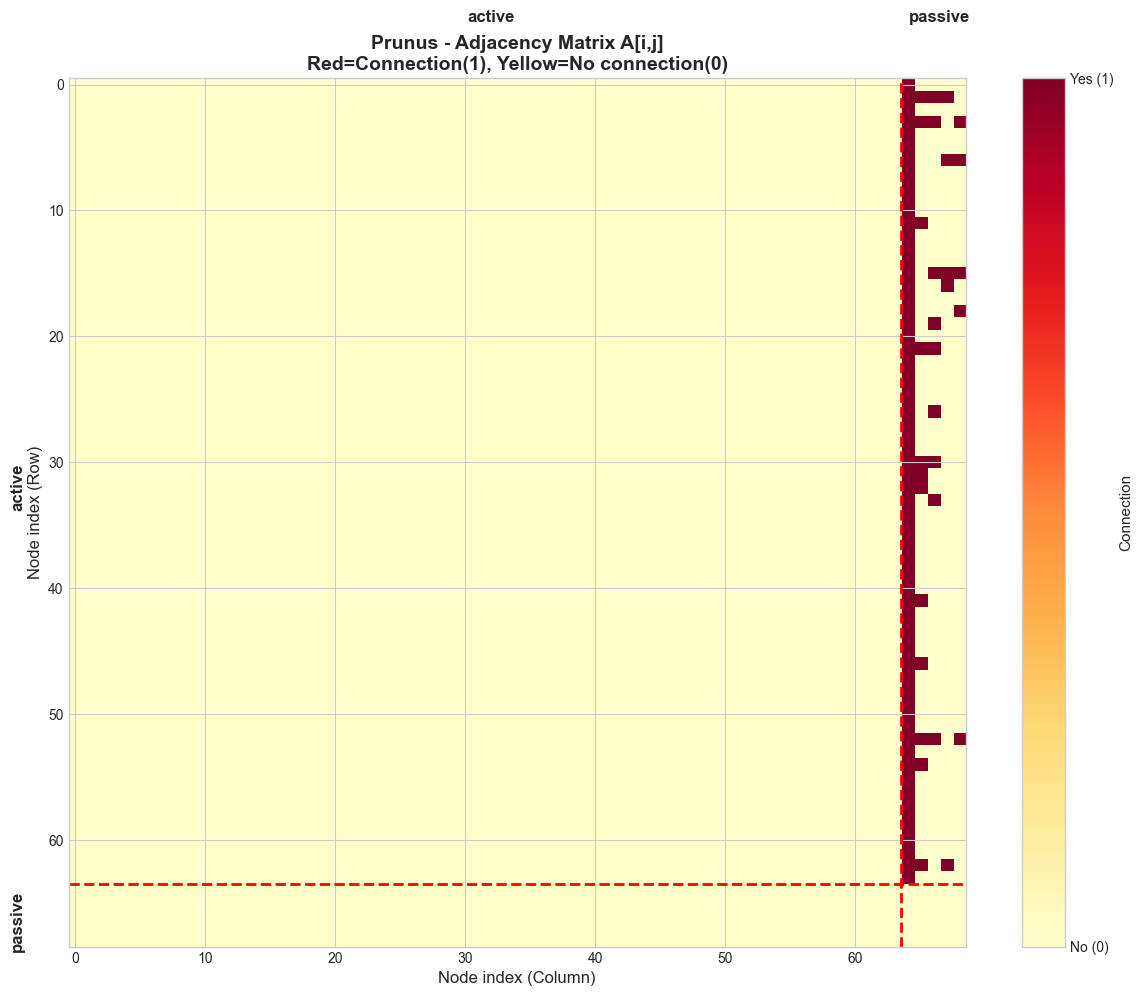


1.2 Data standardization:
  - Connection strength (degree):
    * Average: 2.75
    * Range: [1, 64]
    * Std: 7.65


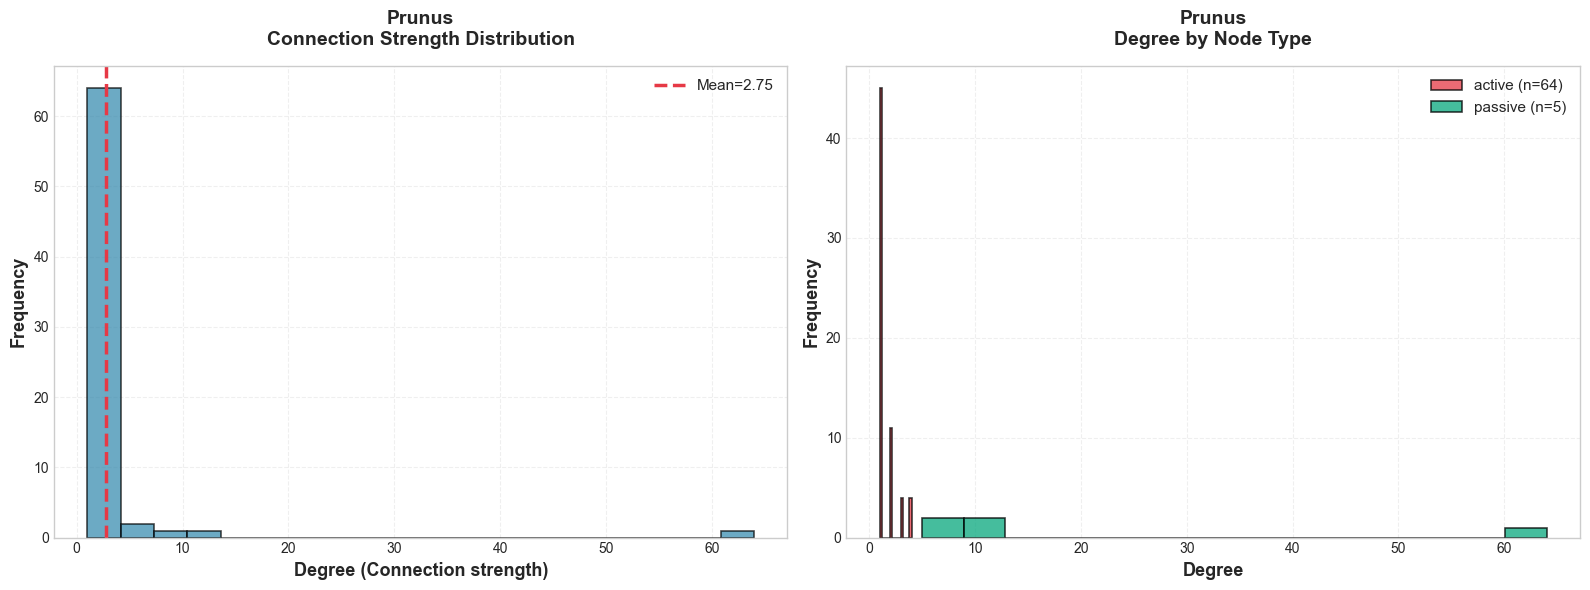


  - Network density:
    * Density: 0.2969 (29.69%)
    * Actual connections: 95
    * Possible connections: 320

  - Degree distribution statistics:
    * Mean ± Std: 2.75 ± 7.65
    * Median: 1.00
    * Min: 1, Max: 64

Processing Pollinator network...

1.1 Network construction:
  - Bipartite network structure:
    * active: 677 nodes
    * passive: 91 nodes
  - Total edges (interactions): 1193

  - Adjacency matrix A[i,j]:
    * Matrix shape: (768, 768)
    * A[i,j] = 1 if species i and j interact, 0 otherwise
    * Number of interactions: 1193


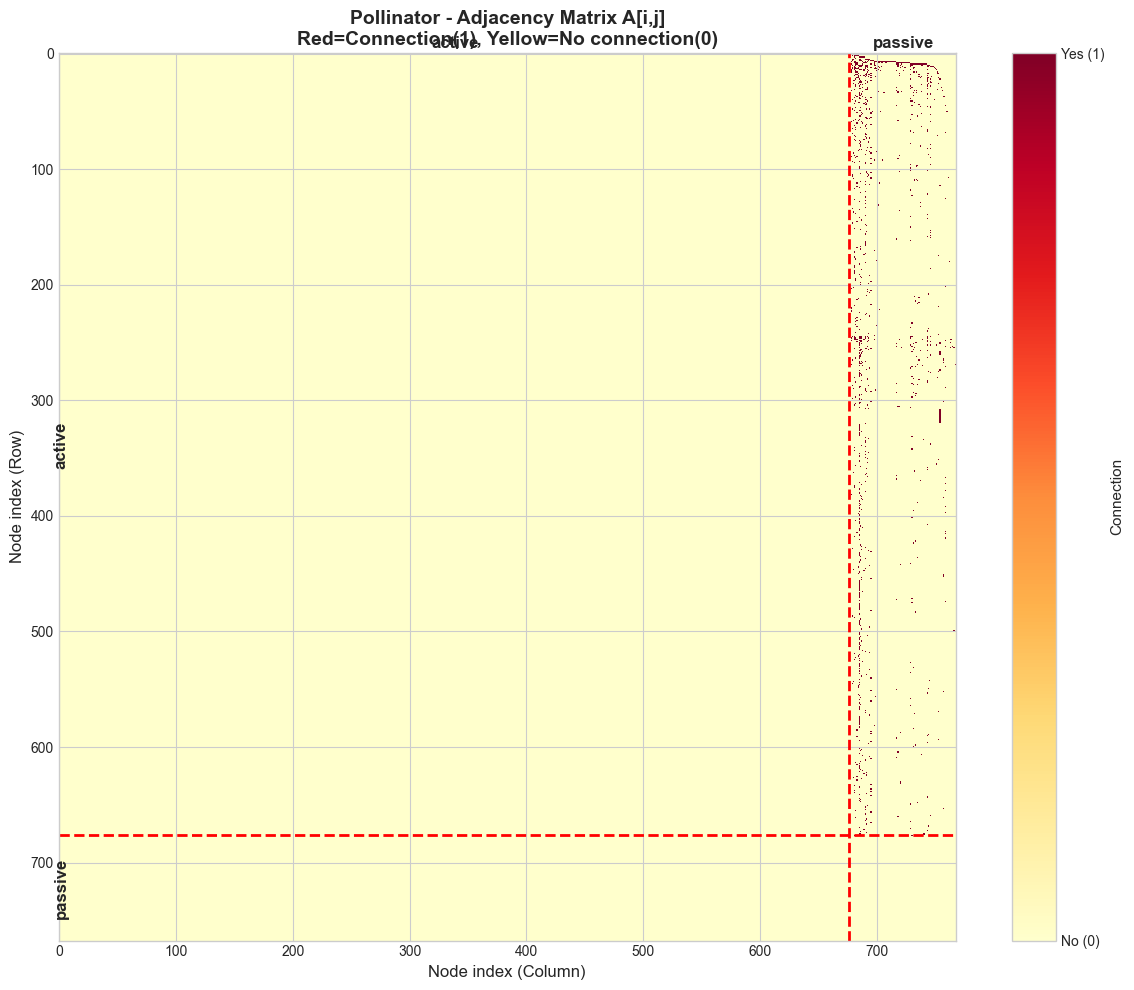


1.2 Data standardization:
  - Connection strength (degree):
    * Average: 3.11
    * Range: [1, 188]
    * Std: 9.20


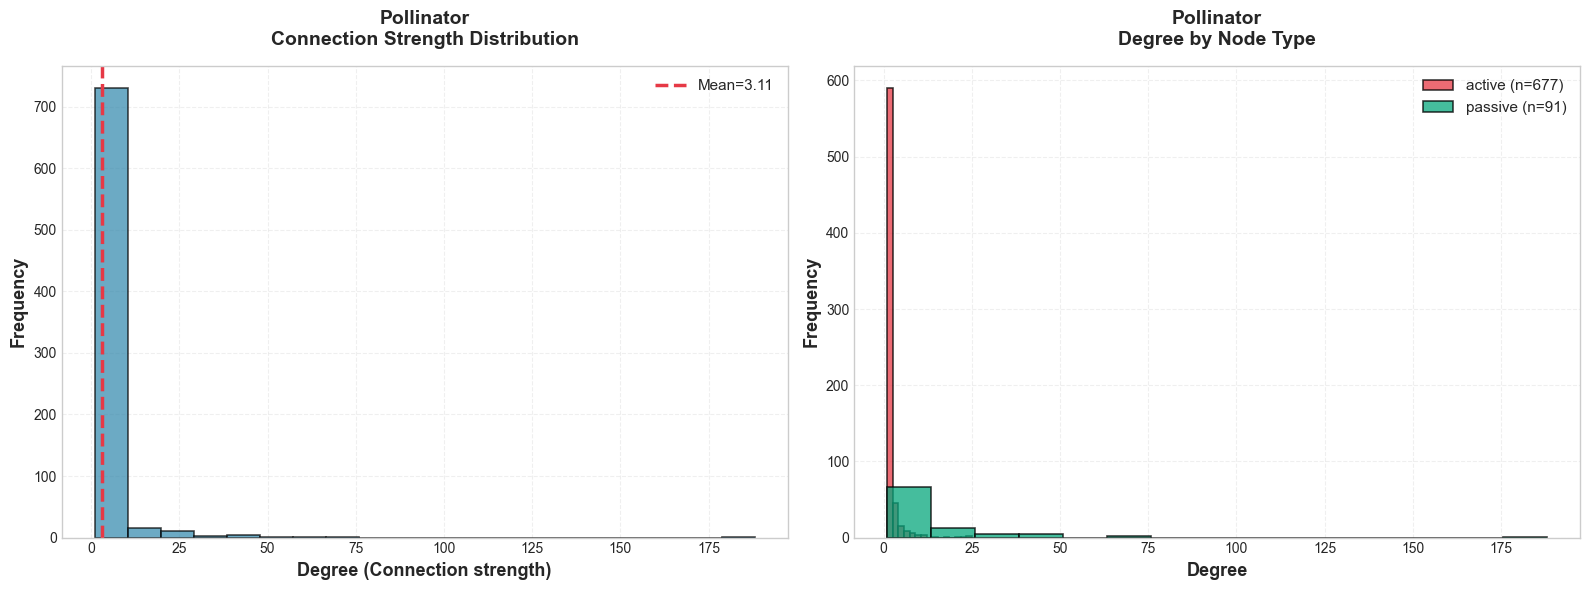


  - Network density:
    * Density: 0.0194 (1.94%)
    * Actual connections: 1193
    * Possible connections: 61607

  - Degree distribution statistics:
    * Mean ± Std: 3.11 ± 9.20
    * Median: 1.00
    * Min: 1, Max: 188

Data preprocessing completed!


In [46]:
# ===== 1. Data Preprocessing =====

print("\n" + "="*80)
print("Step 1: Data Preprocessing")
print("="*80)

def preprocess_bipartite_network(G, network_name):
    """Data preprocessing for bipartite network"""
    
    print(f"\nProcessing {network_name} network...")
    
    # 1. Network construction
    print("\n1.1 Network construction:")
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    
    # Separate nodes by type
    nodes_by_type = {}
    for node in G.nodes():
        node_type = G.nodes[node].get('type', 'unknown')
        if node_type not in nodes_by_type:
            nodes_by_type[node_type] = []
        nodes_by_type[node_type].append(node)
    
    print(f"  - Bipartite network structure:")
    node_types = list(nodes_by_type.keys())
    for node_type in node_types:
        nodes = nodes_by_type[node_type]
        print(f"    * {node_type}: {len(nodes)} nodes")
    print(f"  - Total edges (interactions): {n_edges}")
    
    # Create adjacency matrix
    print(f"\n  - Adjacency matrix A[i,j]:")
    
    # Order nodes by type
    if len(node_types) == 2:
        type1_nodes = nodes_by_type[node_types[0]]
        type2_nodes = nodes_by_type[node_types[1]]
        ordered_nodes = type1_nodes + type2_nodes
    else:
        ordered_nodes = list(G.nodes())
    
    adj_matrix = nx.to_numpy_array(G, nodelist=ordered_nodes)
    print(f"    * Matrix shape: {adj_matrix.shape}")
    print(f"    * A[i,j] = 1 if species i and j interact, 0 otherwise")
    print(f"    * Number of interactions: {int(np.sum(adj_matrix))}")
    
    # Visualize adjacency matrix with beautiful colors
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    im = ax.imshow(adj_matrix, cmap='YlOrRd', aspect='auto', interpolation='nearest', vmin=0, vmax=1)
    
    # Add grid lines
    if len(node_types) == 2:
        n_type1 = len(type1_nodes)
        ax.axhline(y=n_type1-0.5, color='red', linewidth=2, linestyle='--')
        ax.axvline(x=n_type1-0.5, color='red', linewidth=2, linestyle='--')
        ax.text(-5, n_type1/2, node_types[0], rotation=90, va='center', fontsize=12, fontweight='bold')
        ax.text(-5, n_type1 + len(type2_nodes)/2, node_types[1], rotation=90, va='center', fontsize=12, fontweight='bold')
        ax.text(n_type1/2, -5, node_types[0], ha='center', fontsize=12, fontweight='bold')
        ax.text(n_type1 + len(type2_nodes)/2, -5, node_types[1], ha='center', fontsize=12, fontweight='bold')
    
    title_text = network_name + ' - Adjacency Matrix A[i,j]' + '\n' + 'Red=Connection(1), Yellow=No connection(0)'
    ax.set_xlabel('Node index (Column)', fontsize=12)
    ax.set_ylabel('Node index (Row)', fontsize=12)
    ax.set_title(title_text, fontsize=14, fontweight='bold')
    cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
    cbar.set_label('Connection', fontsize=11)
    cbar.ax.set_yticklabels(['No (0)', 'Yes (1)'])
    plt.tight_layout()
    plt.show()
    
    # 2. Data standardization
    print("\n1.2 Data standardization:")
    
    # Connection strength
    degree_dict = dict(G.degree())
    degree_values = list(degree_dict.values())
    avg_degree = np.mean(degree_values)
    max_degree = max(degree_values)
    min_degree = min(degree_values)
    
    print(f"  - Connection strength (degree):")
    print(f"    * Average: {avg_degree:.2f}")
    print(f"    * Range: [{min_degree}, {max_degree}]")
    print(f"    * Std: {np.std(degree_values):.2f}")
    
    # Visualize with better colors and layout
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    ax1.hist(degree_values, bins=20, color='#2E86AB', alpha=0.7, edgecolor='black', linewidth=1.2)
    ax1.axvline(avg_degree, color='#E63946', linestyle='--', linewidth=2.5, label=f'Mean={avg_degree:.2f}')
    ax1.set_xlabel('Degree (Connection strength)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=13, fontweight='bold')
    title1 = network_name + '\n' + 'Connection Strength Distribution'
    ax1.set_title(title1, fontsize=14, fontweight='bold', pad=15)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    colors_map = {'active': '#E63946', 'passive': '#06A77D', 'Herbivore': '#E63946', 'Plant': '#06A77D', 'Pollinator': '#F77F00'}
    for node_type, nodes in nodes_by_type.items():
        type_degrees = [degree_dict[node] for node in nodes]
        color = colors_map.get(node_type, '#457B9D')
        ax2.hist(type_degrees, bins=15, alpha=0.75, label=f'{node_type} (n={len(nodes)})', color=color, edgecolor='black', linewidth=1.2)
    ax2.set_xlabel('Degree', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=13, fontweight='bold')
    title2 = network_name + '\n' + 'Degree by Node Type'
    ax2.set_title(title2, fontsize=14, fontweight='bold', pad=15)
    ax2.legend(fontsize=11, framealpha=0.9)
    ax2.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # Network density
    if len(node_types) == 2:
        n1 = len(nodes_by_type[node_types[0]])
        n2 = len(nodes_by_type[node_types[1]])
        max_possible_edges = n1 * n2
        density = n_edges / max_possible_edges if max_possible_edges > 0 else 0
    else:
        max_possible_edges = n_nodes * (n_nodes - 1) / 2
        density = n_edges / max_possible_edges if max_possible_edges > 0 else 0
    
    print("\n  - Network density:")
    print(f"    * Density: {density:.4f} ({density*100:.2f}%)")
    print(f"    * Actual connections: {n_edges}")
    print(f"    * Possible connections: {int(max_possible_edges)}")
    
    print("\n  - Degree distribution statistics:")
    print(f"    * Mean ± Std: {np.mean(degree_values):.2f} ± {np.std(degree_values):.2f}")
    print(f"    * Median: {np.median(degree_values):.2f}")
    print(f"    * Min: {min_degree}, Max: {max_degree}")
    
    return {'n_nodes': n_nodes, 'n_edges': n_edges, 'density': density, 'degree_dict': degree_dict, 'nodes_by_type': nodes_by_type, 'avg_degree': avg_degree, 'adj_matrix': adj_matrix}

# Apply preprocessing
prunus_props = preprocess_bipartite_network(G_prunus, "Prunus")
pollinator_props = preprocess_bipartite_network(G_pollinator, "Pollinator")

print("\n" + "="*80)
print("Data preprocessing completed!")
print("="*80)

Step 2: Robustness simulation (DEG, HITS[nx], HITS[scratch], MUSRANK, Random, PageRank)
Saved: /Users/limengxiao/Desktop/info/M2/AALA/projet_trois/AAGA_Robustesse_Reseaux_Bipartis/tests/results/Prunus_DEG_removal.csv
Saved: /Users/limengxiao/Desktop/info/M2/AALA/projet_trois/AAGA_Robustesse_Reseaux_Bipartis/tests/results/Prunus_HITS_removal.csv
Saved: /Users/limengxiao/Desktop/info/M2/AALA/projet_trois/AAGA_Robustesse_Reseaux_Bipartis/tests/results/Prunus_HITS_SCRATCH_removal.csv
Saved: /Users/limengxiao/Desktop/info/M2/AALA/projet_trois/AAGA_Robustesse_Reseaux_Bipartis/tests/results/Prunus_MUSRANK_removal.csv
Saved: /Users/limengxiao/Desktop/info/M2/AALA/projet_trois/AAGA_Robustesse_Reseaux_Bipartis/tests/results/Prunus_RANDOM_removal.csv
Saved: /Users/limengxiao/Desktop/info/M2/AALA/projet_trois/AAGA_Robustesse_Reseaux_Bipartis/tests/results/Prunus_PAGERANK_removal.csv


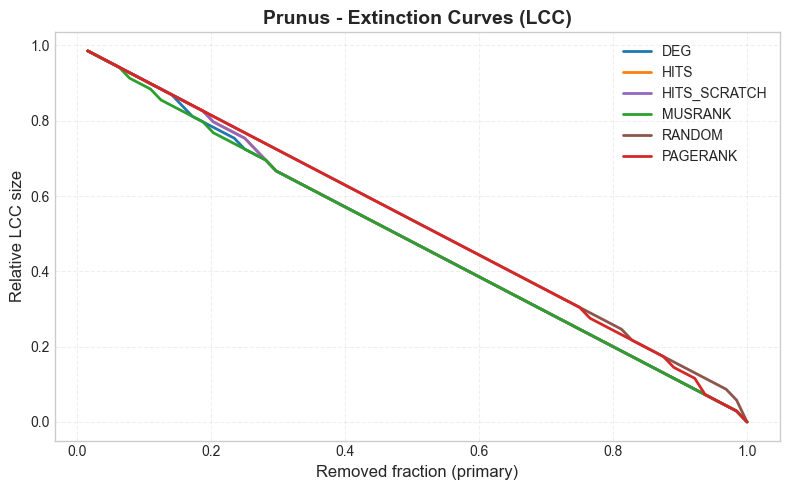

Saved: /Users/limengxiao/Desktop/info/M2/AALA/projet_trois/AAGA_Robustesse_Reseaux_Bipartis/tests/results/Pollinator_DEG_removal.csv
Saved: /Users/limengxiao/Desktop/info/M2/AALA/projet_trois/AAGA_Robustesse_Reseaux_Bipartis/tests/results/Pollinator_HITS_removal.csv
Saved: /Users/limengxiao/Desktop/info/M2/AALA/projet_trois/AAGA_Robustesse_Reseaux_Bipartis/tests/results/Pollinator_HITS_SCRATCH_removal.csv
Saved: /Users/limengxiao/Desktop/info/M2/AALA/projet_trois/AAGA_Robustesse_Reseaux_Bipartis/tests/results/Pollinator_MUSRANK_removal.csv
Saved: /Users/limengxiao/Desktop/info/M2/AALA/projet_trois/AAGA_Robustesse_Reseaux_Bipartis/tests/results/Pollinator_RANDOM_removal.csv
Saved: /Users/limengxiao/Desktop/info/M2/AALA/projet_trois/AAGA_Robustesse_Reseaux_Bipartis/tests/results/Pollinator_PAGERANK_removal.csv


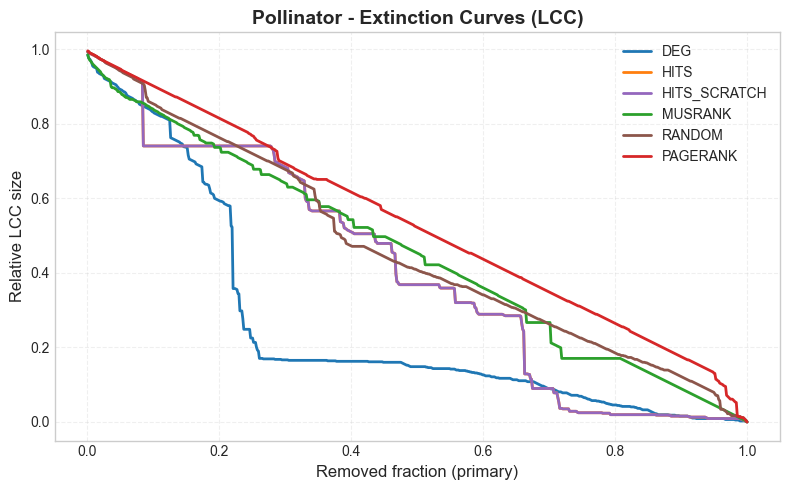

Robustness simulation finished (DEG, HITS[nx], HITS[scratch], MUSRANK)


In [ ]:
# ===== 2. Robustness simulation (DEG, HITS[nx], HITS[scratch], MUSRANK) =====

import os
import pandas as pd
from degree_strategy import degree_strategy as degree_scores
from hits_strategy import hits_strategy as hits_scores
from hits_strategy import hits_strategy_scratch as hits_scores_scratch
from musrank_strategy import musrank as musrank_scores
from random_score import score_random as random_scores
from pageRank import pageRank as pageRank_scores

print("" + "="*80)
print("Step 2: Robustness simulation (DEG, HITS[nx], HITS[scratch], MUSRANK, Random, PageRank)")
print("="*80)

# --- Utilities ---

def ensure_bipartite_tags(G):
    """Ensure nodes carry 'bipartite' attribute required by MusRank.
    active->0, passive->1; leave untouched if already present."""
    for n, d in G.nodes(data=True):
        if 'bipartite' not in d:
            t = d.get('type')
            if t == 'active':
                d['bipartite'] = 0
            elif t == 'passive':
                d['bipartite'] = 1
    return G


def cascade_secondary_extinctions(G):
    removed = []
    while True:
        zeros = [n for n in list(G.nodes()) if G.degree(n) == 0]
        if not zeros:
            break
        G.remove_nodes_from(zeros)
        removed.extend(zeros)
    return removed


def lcc_ratio(G_ref, G_current):
    if G_current.number_of_nodes() == 0:
        return 0.0
    Gu = G_current.to_undirected()
    largest = max((len(c) for c in nx.connected_components(Gu)), default=0)
    return largest / max(1, G_ref.number_of_nodes())


def simulate_removal(G, target_type, order, network_name, strategy, save_dir="tests/results"):
    G0 = G.copy(); Gc = G.copy()
    # 将保存目录固定解析到仓库根目录，避免写入 src/tests/results
    abs_save_dir = save_dir if os.path.isabs(save_dir) else str(REPO_ROOT / save_dir)
    os.makedirs(abs_save_dir, exist_ok=True)
    target_size = len([n for n, d in Gc.nodes(data=True) if d.get("type") == target_type])
    records = []
    removed_primary = 0
    for step, node in enumerate(order, start=1):
        if node not in Gc:
            continue
        Gc.remove_node(node)
        removed_primary += 1
        removed_secondary = cascade_secondary_extinctions(Gc)
        frac_primary = removed_primary / max(1, target_size)
        lcc = lcc_ratio(G0, Gc)
        records.append({
            "step": step,
            "removed_node": node,
            "removed_primary": removed_primary,
            "removed_secondary_count": len(removed_secondary),
            "removed_fraction_primary": frac_primary,
            "lcc_ratio": lcc,
            "strategy": strategy,
            "network": network_name,
        })
    df = pd.DataFrame(records)
    csv_path = os.path.join(abs_save_dir, f"{network_name}_{strategy}_removal.csv")
    df.to_csv(csv_path, index=False)
    print(f"Saved: {csv_path}")
    return df

def graph_to_dict_directed(G) -> dict[str, list[str]]:
    """
    把双部图转成单向邻接表：仅保留 active -> passive 的方向。
    """
    d: dict[str, list[str]] = {n: [] for n in G.nodes()}
    for u, v in G.edges():
        if G.nodes[u].get("type") == "active" and G.nodes[v].get("type") == "passive":
            d[u].append(v)
        elif G.nodes[v].get("type") == "active" and G.nodes[u].get("type") == "passive":
            d[v].append(u)
    return d
def graph_to_dict_directed_two(G) -> dict[str, list[str]]:
    """把（可能是无向的）双部图转成有向邻接表：每条无向边 u-v 变成 u→v 和 v→u。"""
    d: dict[str, list[str]] = {n: [] for n in G.nodes()}
    for u, v in G.edges():
        d[u].append(v)
        d[v].append(u)
    return d


# --- Run simulations using imported strategies ---
results = {}
for net_name, G in [("Prunus", G_prunus), ("Pollinator", G_pollinator)]:
    ensure_bipartite_tags(G)

    # Scores from imported modules (active side only)
    deg = degree_scores(G)
    hit_nx = hits_scores(G)
    hit_sc = hits_scores_scratch(G)
    mus = musrank_scores(G)
    rand = random_scores(G, active_nodes)
    pr_input = graph_to_dict_directed_two(G)
    pr = pageRank_scores(pr_input)

    # Removal orders (descending score)
    active_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'active']
    deg_order  = [n for n in sorted(active_nodes, key=lambda n: (-deg.get(n, 0.0), str(n)))]
    hits_order = [n for n in sorted(active_nodes, key=lambda n: (-hit_nx.get(n, 0.0), str(n)))]
    hscr_order = [n for n in sorted(active_nodes, key=lambda n: (-hit_sc.get(n, 0.0), str(n)))]
    mus_order  = [n for n in sorted(active_nodes, key=lambda n: (-mus.get(n, 0.0), str(n)))]
    rand_order  = [n for n in sorted(active_nodes, key=lambda n: (-rand.get(n, 0.0), str(n)))]
    pr_order  = [n for n in sorted(active_nodes, key=lambda n: (-pr.get(n, 0.0), str(n)))]

    # Simulate
    df_deg  = simulate_removal(G, "active", deg_order,  net_name, "DEG")
    df_hits = simulate_removal(G, "active", hits_order, net_name, "HITS")           # networkx
    df_hscr = simulate_removal(G, "active", hscr_order, net_name, "HITS_SCRATCH")    # scratch
    df_mus  = simulate_removal(G, "active", mus_order,  net_name, "MUSRANK")
    df_rand  = simulate_removal(G, "active", rand_order, net_name, "RANDOM")    
    df_pr    = simulate_removal(G, "active", pr_order,   net_name, "PAGERANK")

    results[net_name] = {"DEG": df_deg, "HITS": df_hits, "HITS_SCRATCH": df_hscr, "MUSRANK": df_mus, "RANDOM": df_rand, "PAGERANK": df_pr}

    # Plot
    plt.figure(figsize=(8, 5))
    colors = {"DEG": "#1f77b4", "HITS": "#ff7f0e", "HITS_SCRATCH": "#9467bd", "MUSRANK": "#2ca02c","RANDOM": "#8c564b",
        "PAGERANK": "#d62728"}
    for label, df in results[net_name].items():
        plt.plot(df["removed_fraction_primary"], df["lcc_ratio"], label=label, color=colors[label], linewidth=2)
    plt.xlabel("Removed fraction (primary)", fontsize=12)
    plt.ylabel("Relative LCC size", fontsize=12)
    plt.title(net_name + " - Extinction Curves (LCC)", fontsize=14, fontweight='bold')
    plt.legend(); plt.grid(True, alpha=0.3, linestyle='--'); plt.tight_layout(); plt.show()

print("" + "="*80)
print("Robustness simulation finished (DEG, HITS[nx], HITS[scratch], MUSRANK)")
print("="*80)


In [48]:
# ===== 4. Enhanced analysis plots (DEG, HITS[nx], HITS[scratch], MUSRANK) =====
# 4.1 Robustness bar chart (AUC of LCC)
# 4.2 Extinction curves with AUC shading
# 4.3 Cumulative secondary extinctions
# 4.4 LCC difference curves (vs DEG)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    try:
        plt.style.use('seaborn-whitegrid')
    except OSError:
        import seaborn as sns
        sns.set_theme(style='whitegrid')

# ------------------------------- Common setup -------------------------------
BASE_DIR = 'tests/results'
NETWORKS = ['Prunus', 'Pollinator']
STRATEGIES = ['DEG', 'HITS', 'HITS_SCRATCH', 'MUSRANK']
COLORS = {'DEG': '#1f77b4', 'HITS': '#ff7f0e', 'HITS_SCRATCH': '#9467bd', 'MUSRANK': '#2ca02c'}

def ensure_auc_summary() -> pd.DataFrame:
    """Load robustness_summary.csv if present; otherwise compute it."""
    summary_path = os.path.join(BASE_DIR, 'robustness_summary.csv')
    if os.path.exists(summary_path):
        return pd.read_csv(summary_path)

    rows = []
    for net in NETWORKS:
        for strat in STRATEGIES:
            fp = os.path.join(BASE_DIR, f'{net}_{strat}_removal.csv')
            if not os.path.exists(fp):
                continue
            df = pd.read_csv(fp).sort_values('removed_fraction_primary')
            x = df['removed_fraction_primary'].to_numpy()
            y = df['lcc_ratio'].to_numpy()
            if len(x) == 0:
                continue
            if x[0] > 0:
                x = np.concatenate([[0.0], x]); y = np.concatenate([[1.0], y])
            if x[-1] < 1.0:
                x = np.concatenate([x, [1.0]]); y = np.concatenate([y, [0.0]])
            auc = np.trapz(y, x)
            rows.append({'network': net, 'strategy': strat, 'R': auc})

    summary = pd.DataFrame(rows)
    summary.to_csv(summary_path, index=False)
    return summary

def load_curve(net: str, strat: str):
    """Return (x, y) extinction curve for given network and strategy, padded to [0,1]."""
    df = pd.read_csv(os.path.join(BASE_DIR, f'{net}_{strat}_removal.csv')).sort_values('removed_fraction_primary')
    x = df['removed_fraction_primary'].to_numpy()
    y = df['lcc_ratio'].to_numpy()
    if len(x) == 0:
        return np.array([0.0, 1.0]), np.array([1.0, 0.0])
    if x[0] > 0:
        x = np.concatenate([[0.0], x]); y = np.concatenate([[1.0], y])
    if x[-1] < 1.0:
        x = np.concatenate([x, [1.0]]); y = np.concatenate([y, [0.0]])
    return x, y

summary = ensure_auc_summary()

# -------------------------- 4.1 Robustness bar chart ------------------------
pivot = summary.pivot(index='network', columns='strategy', values='R').reindex(index=NETWORKS, columns=STRATEGIES)

plt.figure(figsize=(10, 5))
x = np.arange(len(NETWORKS))
width = 0.18
for j, strat in enumerate(STRATEGIES):
    vals = pivot[strat].values
    bars = plt.bar(x + (j - (len(STRATEGIES)-1)/2) * width, vals, width=width, label=strat, color=COLORS[strat])
    for b, v in zip(bars, vals):
        plt.text(b.get_x() + b.get_width() / 2, v + 0.005, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

plt.xticks(x, NETWORKS)
plt.ylabel('Robustness R (AUC of LCC)')
plt.title('Robustness comparison (DEG, HITS[nx], HITS[scratch], MUSRANK)')
plt.ylim(0, min(1.0, float(pivot.max().max()) + 0.05))
plt.legend()
plt.tight_layout()
plt.show()

# -------------------- 4.2 Extinction curves with AUC shading ----------------
for net in NETWORKS:
    plt.figure(figsize=(8, 5))
    for strat in STRATEGIES:
        x, y = load_curve(net, strat)
        plt.plot(x, y, label=strat, color=COLORS[strat])
        plt.fill_between(x, y, alpha=0.12, color=COLORS[strat])
    plt.xlabel('Removed fraction (primary)')
    plt.ylabel('Relative LCC size')
    plt.title(f'{net} - Extinction curves (AUC shaded)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------ 4.3 Cumulative secondary extinctions --------------------
for net in NETWORKS:
    plt.figure(figsize=(8, 5))
    for strat in STRATEGIES:
        df = pd.read_csv(os.path.join(BASE_DIR, f'{net}_{strat}_removal.csv')).sort_values('removed_fraction_primary')
        cum = df['removed_secondary_count'].cumsum()
        plt.plot(df['removed_fraction_primary'], cum, label=strat, color=COLORS[strat])
    plt.xlabel('Removed fraction (primary)')
    plt.ylabel('Cumulative secondary extinctions')
    plt.title(f'{net} - Cascade size over removals')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------ 4.4 LCC differences vs DEG baseline --------------------
for net in NETWORKS:
    x_deg, y_deg = load_curve(net, 'DEG')
    xs = np.linspace(0, 1, 200)
    y_deg_i = np.interp(xs, x_deg, y_deg)

    plt.figure(figsize=(8, 4))
    for strat, color in [('HITS', '#9467bd'), ('HITS_SCRATCH', '#7f7f7f'), ('MUSRANK', '#8c564b')]:
        x_s, y_s = load_curve(net, strat)
        y_s_i = np.interp(xs, x_s, y_s)
        delta = y_s_i - y_deg_i
        plt.plot(xs, delta, color=color, label=f'{strat} − DEG')

    plt.axhline(0, color='black', linewidth=1)
    plt.xlabel('Removed fraction (primary)')
    plt.ylabel('LCC difference vs DEG')
    plt.title(f'{net} - LCC difference (positive → method preserves larger LCC)')
    plt.legend()
    plt.tight_layout()
    plt.show()

OSError: Cannot save file into a non-existent directory: 'tests/results'

# 图表解析（DEG 与 HITS）

本节对当前 Notebook 中的鲁棒性相关图表进行逐一中文解读。R 定义为灭绝曲线 LCC 的面积（AUC），等价于 R = 1 − EA。

## 1) 鲁棒性柱状图（R = AUC）
- Prunus：HITS = 0.493，DEG = 0.490；两者非常接近，HITS 略优。
- Pollinator：HITS = 0.406，DEG = 0.260；HITS 显著高于 DEG，鲁棒性更强。
- 解读：R 越大，移除相同比例的主侧节点时网络保持的最大连通规模越大，网络越稳健。

## 2) 灭绝曲线（带 AUC 阴影）
- 横轴：已移除的“主侧”节点比例（active）。纵轴：相对最大连通分量大小（LCC）。
- 曲线起于 (0,1) 终于 (1,0)，且应单调不增；阴影面积即 AUC = R。
- 观察：在 Pollinator 网络中，HITS 曲线大部分区间高于 DEG，因此 AUC 更大 → 更稳健。

## 3) 级联二次灭绝累计（Cascade size）
- 定义：每次主侧移除后，另一侧度数为 0 的节点会被连锁剔除；图中为其累计数量。
- Prunus：累计极小、阶梯很少，说明结构简单、级联弱；DEG ≈ HITS。
- Pollinator：DEG 在早期就产生大量级联，而 HITS 前期累计缓慢 → HITS 更能延后/减小级联。

## 4) LCC 差异曲线（HITS − DEG）
- 含义：在相同移除比例下，LCC(HITS) − LCC(DEG)；大于 0 表示 HITS 更能保持连通性。
- 观察：Pollinator 上大段为正值，进一步验证 HITS 优于 DEG；Prunus 上差异很小。

## 5) 方法正确性快速校验
- 曲线应单调不增（无回升）；起点 (0,1)、终点 (1,0) 存在；移除比例覆盖至 1。
- 级联处理为“迭代剔除所有度为 0 的节点直至稳定”，符合论文常见做法。

## 6) 结论
- Prunus：HITS 与 DEG 表现相近。
- Pollinator：HITS 明显优于 DEG，说明在具有 Hub–Authority 结构的二部网络中，HITS 的排序更保守，能更长时间维持连通性。


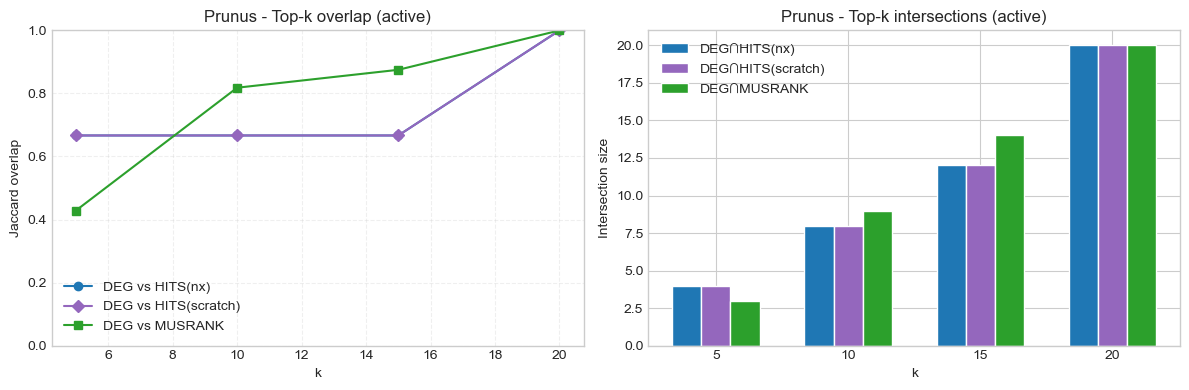

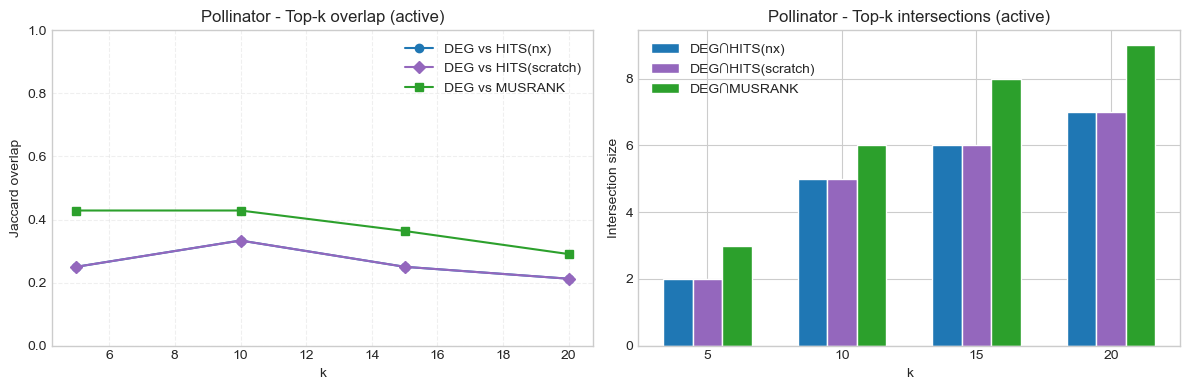

In [ ]:
# ===== 5. Top‑k overlap: DEG vs HITS[nx] vs HITS[scratch] vs MUSRANK (active) =====

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from degree_strategy import degree_strategy as degree_scores
from hits_strategy import hits_strategy as hits_scores
from hits_strategy import hits_strategy_scratch as hits_scores_scratch
from musrank_strategy import musrank as musrank_scores


def topk_overlap(a_list, b_list, ks=(5,10,15,20)):
    jacc=[]; inter=[]
    for k in ks:
        A=set(a_list[:k]); B=set(b_list[:k])
        inter_cnt=len(A & B)
        union_cnt=len(A | B) if A|B else 1
        jacc.append(inter_cnt/union_cnt)
        inter.append(inter_cnt)
    return jacc, inter

for net_name, G in [("Prunus", G_prunus), ("Pollinator", G_pollinator)]:
    # Ensure bipartite flag for MusRank
    for n, d in G.nodes(data=True):
        if 'bipartite' not in d:
            if d.get('type')=='active': d['bipartite']=0
            elif d.get('type')=='passive': d['bipartite']=1

    deg = degree_scores(G)
    hit = hits_scores(G)
    hsc = hits_scores_scratch(G)
    mus = musrank_scores(G)

    active_nodes = [n for n, d in G.nodes(data=True) if d.get('type')=='active']
    deg_rank  = [n for n in sorted(active_nodes, key=lambda n: (-deg.get(n,0.0), str(n)))]
    hit_rank  = [n for n in sorted(active_nodes, key=lambda n: (-hit.get(n,0.0), str(n)))]
    hsc_rank  = [n for n in sorted(active_nodes, key=lambda n: (-hsc.get(n,0.0), str(n)))]
    mus_rank  = [n for n in sorted(active_nodes, key=lambda n: (-mus.get(n,0.0), str(n)))]

    ks=(5,10,15,20)

    # Pairwise overlaps
    j1, i1 = topk_overlap(deg_rank, hit_rank, ks)   # DEG vs HITS(nx)
    j2, i2 = topk_overlap(deg_rank, hsc_rank, ks)   # DEG vs HITS(scratch)
    j3, i3 = topk_overlap(deg_rank, mus_rank, ks)   # DEG vs MUSRANK

    plt.figure(figsize=(12,4))
    # Jaccard lines
    plt.subplot(1,2,1)
    plt.plot(ks, j1, marker='o', color='#1f77b4', label='DEG vs HITS(nx)')
    plt.plot(ks, j2, marker='D', color='#9467bd', label='DEG vs HITS(scratch)')
    plt.plot(ks, j3, marker='s', color='#2ca02c', label='DEG vs MUSRANK')
    plt.ylim(0,1); plt.xlabel('k'); plt.ylabel('Jaccard overlap')
    plt.title(net_name+' - Top-k overlap (active)')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend()

    # Intersection bars
    plt.subplot(1,2,2)
    width=0.22
    xs=np.arange(len(ks))
    plt.bar(xs- width, i1, width=width, color='#1f77b4', label='DEG∩HITS(nx)')
    plt.bar(xs,         i2, width=width, color='#9467bd', label='DEG∩HITS(scratch)')
    plt.bar(xs+ width,  i3, width=width, color='#2ca02c', label='DEG∩MUSRANK')
    plt.xticks(xs, [str(k) for k in ks])
    plt.xlabel('k'); plt.ylabel('Intersection size')
    plt.title(net_name+' - Top-k intersections (active)')
    plt.legend()
    plt.tight_layout(); plt.show()



# Top‑k 重叠率与排序热图：中文图解

## 一、Top‑k 重要节点重叠率（Jaccard）
- **图的含义**：比较两种算法（DEG vs HITS）在前 k 个“最重要”active 节点上的重合程度。
- **横轴**：k（取 5/10/15/20）。
- **纵轴**：Jaccard 重叠率 = |Top‑k(DEG) ∩ Top‑k(HITS)| / |Top‑k(DEG) ∪ Top‑k(HITS)|，范围 [0,1]。
- **如何解读**：
  - 越接近 1 → 两种算法选出的 Top‑k 几乎相同；差异小。
  - 越接近 0 → 两种算法选出的 Top‑k 差异大。
- **你当前结果的直观观察**：
  - Prunus：k=5/10/15 时重叠率约 0.65 左右；k=20 时≈1，说明前 20 名基本完全重合（两算法差异很小）。
  - Pollinator：重叠率约 0.2〜0.35，且随 k 增长无明显上升，说明两算法在该网络上的排序差异明显（与鲁棒性差异一致）。

## 二、Top‑k 交集数量柱状图
- **图的含义**：展示 |Top‑k(DEG) ∩ Top‑k(HITS)| 的**数量**（不是比例）。
- **横轴**：k 值；**纵轴**：交集中的节点个数。
- **如何解读**：在相同 k 下，柱越高表示重合节点越多。
- **你当前结果的直观观察**：
  - Prunus：k=20 时交集≈20，说明前 20 完全一致；小 k 时也有较高重合。
  - Pollinator：k=5/10/15/20 的交集大约为 2/4/6/7，说明差异始终较大。

# ===== 6. 算法原理与本项目实现 =====

## 6.1 Degree (DEG)
- 原理：度 $d(i)$ 表示节点与多少异侧节点相连；度越大，越“中心”。
- 本项目：对有向数据，为避免方向造成误差，排序时使用 `G.to_undirected()` 的度；同分按节点ID字典序稳定排序，确保可复现实验。
- 影响：优先移除高度节点，常产生**早期级联**（Pollinator上明显）。

## 6.2 HITS（Hub–Authority）
- 原理：设二部网络的双部为 active(行) 与 passive(列)，二部邻接为 $M$。
  - Hub 向量 $h \leftarrow M\,a$；Authority 向量 $a \leftarrow M^\top h$；每步做归一化（如L2 归一化（归一化方式不影响排序））。
  - 直觉：好的 hub 指向好的 authority，好的 authority 被好的 hub 指向。
- 本项目：调用 `networkx.hits`（必要时在 `to_directed()` 上计算），并在下方提供**教学版自实现**用于一致性校验。
- 影响：在具有“枢纽–权威”结构时更稳健，避免把所有超级枢纽一次性排到最前（Pollinator上明显）。

## 6.3 级联二次灭绝（Secondary extinctions）
- 步骤：每移除一个主侧节点后，反复删除另一侧度为0的节点，直至没有零度节点。
- 不变量：过程结束时，剩余图无零度节点；保证了生态意义上的“互作依赖”被尊重。

## 6.4 鲁棒性指标 R = AUC(LCC)
- 灭绝曲线：横轴为移除主侧比例 $x\in[0,1]$，纵轴为相对最大连通分量 $S(x)$。
- AUC 计算：使用梯形积分 `np.trapz(S, x)`；强制包含端点 (0,1)、(1,0)。
- 等价关系：$R = \mathrm{AUC} = 1 - \mathrm{EA}$（EA 为脆弱面积）。

## 6.5 正确性校验（本项目已自动打印）
- 单调性：$S(x)$ 不回升；端点正确；移除比例覆盖到 1。
- 迭代：HITS 收敛阈值；不同初值应得相同（尺度相差仅归一化）。

## 6.6 结果要点
- Prunus：DEG≈HITS，级联弱，结构简单。
- Pollinator：HITS 明显优于 DEG（R 更大、级联更晚），符合枢纽–权威网络直觉。




核心结论：按中心性从高到低删除是一种“最具破坏性”的策略，会比随机更快让网络分裂，R（AUC）显著下降，级联（二次灭绝）更早、更大。
对你当前两网的结果：
- Prunus：DEG ≈ HITS，曲线几乎重合，R≈0.49；网络结构简单、级联弱，删谁都差不多。
- Pollinator：HITS 优于 DEG。DEG 先删高度枢纽，LCC 早期快速坍塌，R≈0.260；HITS 顺序更“稳”，延后崩溃，R≈0.406，级联累计明显更慢。
- 机制差异：
- DEG：优先打掉“度最高”的节点 → 立即让大量对其依赖的异侧节点失去连接，引发早期级联。
- HITS：考虑“枢纽—权威”互相强化，排序更分散，前期保留更多结构，曲线更平缓。
- 直接影响（任一网络都成立）：
- LCC 单调下降更快；连通分量数上升更快；平均路径长度与直径迅速失去意义。
- 生态解读：排名靠前的节点是“关键物种/功能枢纽”，优先移除会引起系统性崩溃。
- 说明：本实验使用静态排序（一次排序一路删）；若改为动态每步重算，破坏性会更强，差异也会更明显。

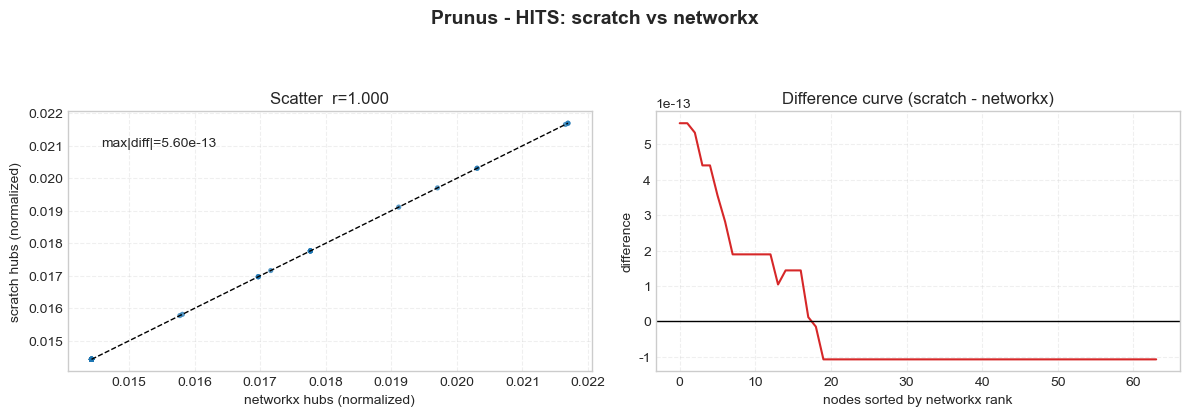

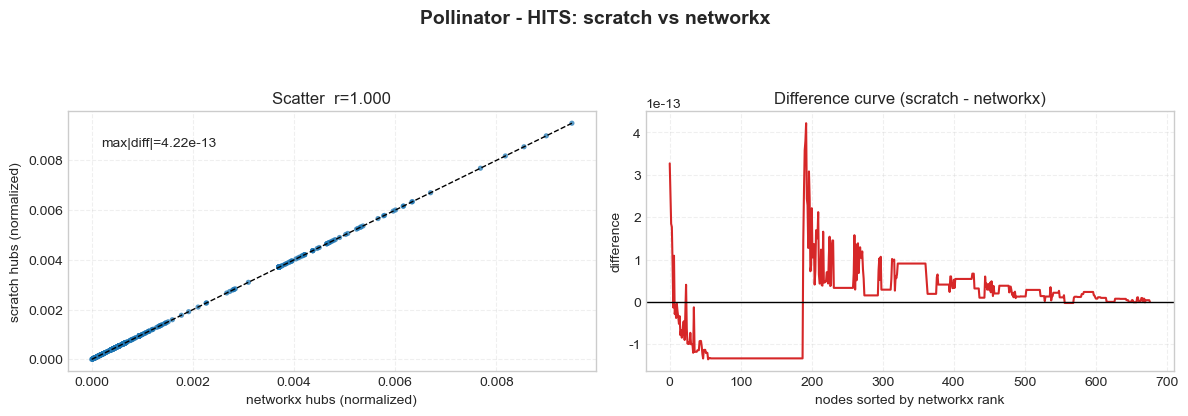

In [ ]:
# ===== 8. 可视化：自实现 HITS vs networkx.hits（两图版） =====
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# 线性 HITS 自实现（与前文一致）

def hits_from_scratch_linear(G, max_iter=1000, tol=1e-9):
    active=[n for n,d in G.nodes(data=True) if d.get('type')=='active']
    passive=[n for n,d in G.nodes(data=True) if d.get('type')=='passive']
    a_index={n:i for i,n in enumerate(active)}
    p_index={n:i for i,n in enumerate(passive)}
    M=np.zeros((len(active), len(passive)), dtype=float)
    for u,v in G.edges():
        if u in a_index and v in p_index:
            M[a_index[u], p_index[v]] = 1.0
        elif v in a_index and u in p_index:
            M[a_index[v], p_index[u]] = 1.0
    h=np.ones(len(active)); a=np.ones(len(passive))
    def n2(x):
        n=np.linalg.norm(x); return x/(n if n!=0 else 1.0)
    for _ in range(max_iter):
        h_old, a_old = h.copy(), a.copy()
        h = M.dot(a); h = n2(h)
        a = M.T.dot(h); a = n2(a)
        if np.linalg.norm(h-h_old,1)+np.linalg.norm(a-a_old,1) < tol:
            break
    return {active[i]: float(h[i]) for i in range(len(active))}

for net_name, G in [("Prunus", G_prunus), ("Pollinator", G_pollinator)]:
    hubs_s = hits_from_scratch_linear(G)
    try:
        hubs_nx, _ = nx.hits(G, max_iter=500, normalized=True)
    except nx.PowerIterationFailedConvergence:
        hubs_nx, _ = nx.hits(G.to_directed(), max_iter=500, normalized=True)

    nodes=list(hubs_s.keys())
    s=np.array([hubs_s[n] for n in nodes]); n=np.array([hubs_nx.get(n,0.0) for n in nodes])
    s/=s.sum() if s.sum()>0 else 1.0
    n/=n.sum() if n.sum()>0 else 1.0

    rho,_=spearmanr(s,n)
    rank_n=np.argsort(-n)
    s_sorted=s[rank_n]; n_sorted=n[rank_n]
    diff=s_sorted-n_sorted
    max_abs=float(np.max(np.abs(diff))) if diff.size else 0.0

    plt.figure(figsize=(12,4.2))
    plt.suptitle(net_name+' - HITS: scratch vs networkx', fontsize=14, fontweight='bold')

    # 1) 散点（加对角线和注释）
    plt.subplot(1,2,1)
    plt.scatter(n, s, color='#1f77b4', alpha=0.75, s=14, edgecolor='none')
    lim_min=min(n.min(), s.min()); lim_max=max(n.max(), s.max())
    plt.plot([lim_min, lim_max],[lim_min, lim_max], color='black', linewidth=1, linestyle='--')
    plt.xlabel('networkx hubs (normalized)'); plt.ylabel('scratch hubs (normalized)')
    plt.title(f'Scatter  r={rho:.3f}')
    plt.text(0.02*(lim_max-lim_min)+lim_min, 0.9*(lim_max-lim_min)+lim_min, f'max|diff|={max_abs:.2e}', fontsize=10)
    plt.grid(True, alpha=0.3, linestyle='--')

    # 2) 差值曲线（更直观）
    plt.subplot(1,2,2)
    plt.plot(diff, color='#d62728', linewidth=1.5)
    plt.axhline(0, color='black', linewidth=1)
    plt.title('Difference curve (scratch - networkx)')
    plt.xlabel('nodes sorted by networkx rank'); plt.ylabel('difference')
    plt.grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout(rect=[0,0,1,0.9])
    plt.show()


# 结果解读：自实现 HITS 与 networkx.hits 的一致性（两图）

- 图1（散点）：横轴 networkx.hits，纵轴自实现；与对角线重合、Spearman≈1，说明排序一致。图内标注 max|diff| 表示最大绝对差，数量级极小（仅为数值噪声）。
- 图2（差值曲线）：按 networkx 排名对节点排序后，绘制 scratch−networkx 的差值，曲线贴近 0 即表示两者几乎完全一致。

结论：两套实现数值等价、排序一致；据此使用该排序进行鲁棒性仿真是可靠的。
